In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Fetch the webpage content
url = 'https://starbucksmenuprices.com/'
response = requests.get(url)
if response.status_code == 200:
    print("Successfully fetched the webpage!")
else:
    print(f"Failed to fetch webpage. Status code: {response.status_code}")

# Step 2: Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Step 3: Find all <ul> elements
sections = soup.find_all('ul')

# Step 4: Extract links
country_links = []
for section in sections:
    links = section.find_all('a')
    for link in links:
        country_name = link.text.strip()
        country_url = link.get('href')
        country_links.append({'Country': country_name, 'URL': country_url})

# Step 5: Convert to DataFrame
df = pd.DataFrame(country_links)
print(df.head())  # Display the first 5 rows

# Step 6: Save to CSV
df.to_csv('starbucks_country_links.csv', index=False)
print("Saved country links to starbucks_country_links.csv")

Successfully fetched the webpage!
     Country                                                URL
0        A-C                                                  #
1  Australia  https://starbucksmenuprices.com/starbucks-au-p...
2     Brasil  https://starbucksmenuprices.com/starbucks-bras...
3   Bulgaria  https://starbucksmenuprices.com/starbucks-%d1%...
4     Canada  https://starbucksmenuprices.com/starbucks-cana...
Saved country links to starbucks_country_links.csv


In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

# Step 1: Load the Links
links_file = 'starbucks_country_links.csv'  # File containing country links
country_links = pd.read_csv(links_file)  # Read the CSV file into a DataFrame

# Step 2: Filter Valid Links
valid_links = country_links[~country_links['URL'].str.contains('#', na=False)]  # Remove invalid URLs containing '#'

# Check if there are any valid links
if valid_links.empty:
    print("No valid links found in the file.")
    exit()

# Step 3: Loop Over All Valid Links
for index, row in valid_links.iterrows():
    country_url = row['URL']  # Extract the URL
    country_name = row['Country'].lower().replace(' ', '-')  # Format the country name for the file name

    print(f"Fetching data for {country_name} from {country_url}...")

    # Step 4: Fetch the Webpage Content
    response = requests.get(country_url)
    if response.status_code == 200:
        print(f"Successfully fetched the page: {country_url}")
    else:
        print(f"Failed to fetch webpage for {country_name}. Status code: {response.status_code}")
        continue  # Skip this country if the webpage request fails

    # Step 5: Parse the HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Step 6: Locate "h2" Section Containing Starbucks Prices
    starbucks_prices_heading = soup.find('h2')  # Locate the "h2" section heading
    if starbucks_prices_heading:
        starbucks_prices_table = starbucks_prices_heading.find_parent('table')  # Find the parent table containing the data
    else:
        print(f"'Hot Coffee' section not found for {country_name}. Skipping...")
        continue  # Skip to the next country if no relevant section is found

    # Step 7: Extract Data
    starbucks_prices_data = []  # List to store extracted data
    if starbucks_prices_table:
        rows = starbucks_prices_table.find_all('tr', class_='item')  # Find all rows with class "item"
        for row in rows:
            cols = row.find_all('td')  # Find all columns in the row
            cols = [col.string.strip() if col.string else '' for col in cols]  # Clean the text and handle missing values
            if cols:  # Skip empty rows
                starbucks_prices_data.append(cols)

    # Step 8: Save Data
    if starbucks_prices_data:
        df_starbucks_prices = pd.DataFrame(starbucks_prices_data, columns=['Item', 'Price'])  # Create a DataFrame
        output_file = f'starbucks_prices_{country_name}.csv'  # Generate file name with country name
        df_starbucks_prices.to_csv(output_file, index=False)  # Save to CSV
        print(f"Saved 'Starbucks Prices' prices to {output_file}")
    else:
        print(f"No 'Starbucks Prices Data' found for {country_name}. Skipping...")

Fetching data for australia from https://starbucksmenuprices.com/starbucks-au-prices/...
Successfully fetched the page: https://starbucksmenuprices.com/starbucks-au-prices/
Saved 'Starbucks Prices' prices to starbucks_prices_australia.csv
Fetching data for brasil from https://starbucksmenuprices.com/starbucks-brasil-precos/...
Successfully fetched the page: https://starbucksmenuprices.com/starbucks-brasil-precos/
Saved 'Starbucks Prices' prices to starbucks_prices_brasil.csv
Fetching data for bulgaria from https://starbucksmenuprices.com/starbucks-%d1%86%d0%b5%d0%bd%d0%b8/...
Successfully fetched the page: https://starbucksmenuprices.com/starbucks-%d1%86%d0%b5%d0%bd%d0%b8/
Saved 'Starbucks Prices' prices to starbucks_prices_bulgaria.csv
Fetching data for canada from https://starbucksmenuprices.com/starbucks-canada-menu/...
Successfully fetched the page: https://starbucksmenuprices.com/starbucks-canada-menu/
Saved 'Starbucks Prices' prices to starbucks_prices_canada.csv
Fetching data fo

In [3]:
import os
import pandas as pd

# Step 1: Define the folder path containing the CSV files
folder_path = './'  # Adjust to the directory where the files are stored

# Step 2: Initialize a list to store latte prices data
worldwide_latte_prices = []

# Step 3: Loop through files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file matches the pattern "starbucks_prices_[country].csv"
    if file_name.startswith('starbucks_prices_') and file_name.endswith('.csv'):
        # Extract the country name from the file name
        country_name = file_name.replace('starbucks_prices_', '').replace('.csv', '').capitalize()
        
        # Load the CSV file into a DataFrame
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Step 4: Search for a row containing 'Latte'
        for _, row in df.iterrows():
            if 'latte' in row['Item'].lower():  # Case-insensitive search for "latte"
                latte_price = row['Price']
                # Append the country name and latte price to the list
                worldwide_latte_prices.append({'Country': country_name, 'Latte Price': latte_price})
                break  # Stop after finding the first matching "latte"

# Step 5: Save the consolidated data to a new CSV file
output_file = 'worldwide_latte_prices.csv'
df_worldwide = pd.DataFrame(worldwide_latte_prices)
df_worldwide.to_csv(output_file, index=False)

print(f"Worldwide latte prices saved to {output_file}")
print(df_worldwide)

Worldwide latte prices saved to worldwide_latte_prices.csv
           Country Latte Price
0            Italy       €1.50
1   Czech-republic    Kč165.00
2            Chile  $11,684.62
3           México      $92.41
4          Hungary  Ft2,190.00
5     South-africa      R48.00
6           Poland     zł10.90
7        Australia       $6.88
8    United-states       $5.03
9           Brasil     R$16.86
10         Finland       €6.20
11        Colombia  $27,400.00
12          Canada      $10.35
13  United-kingdom       £3.36


In [4]:
import pandas as pd
import pycountry

# Step 1: Load Data
file_path = "worldwide_latte_prices.csv"  # Change this to your actual file name
df = pd.read_csv(file_path)

# Step 2: Function to Standardize Country Names
def standardize_country_name(country):
    try:
        # Convert country name to lowercase and remove leading/trailing spaces
        country = country.strip().lower()
        
        # Handle common non-standard names manually
        country_corrections = {
            "czech-republic": "Czech Republic",
            "south-africa": "South Africa",
            "united-states": "United States",
            "united-kingdom": "United Kingdom",
            "méxico": "Mexico",
            "brasil": "Brazil",
            "italy": "Italy",
            "hungary": "Hungary",
            "finland": "Finland",
            "colombia": "Colombia",
            "canada": "Canada",
            "poland": "Poland",
            "australia": "Australia",
            "chile": "Chile"
        }

        # Check for manual corrections first
        if country in country_corrections:
            return country_corrections[country]

        # Use pycountry to get standard country names
        country_obj = pycountry.countries.lookup(country)
        return country_obj.name  # Return the official English name

    except LookupError:
        return country  # If no match is found, return the original name

# Step 3: Apply the function to the "Country" column
df["Country"] = df["Country"].apply(standardize_country_name)

# Step 4: Remove Duplicates (if any)
df = df.drop_duplicates()

# Step 5: Save the cleaned file
output_file = "latte_prices_standardized.csv"
df.to_csv(output_file, index=False)

print(f"✅ Standardized country names saved to {output_file}")

✅ Standardized country names saved to latte_prices_standardized.csv


In [5]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time

# Step 1: Load country data
csv_file = 'latte_prices_standardized.csv'  # Ensure the correct file name
countries = pd.read_csv(csv_file)

# Set up Selenium WebDriver
driver = webdriver.Chrome()  # Ensure you have ChromeDriver installed

# Function to get exchange rate from DuckDuckGo
def get_exchange_rate_from_duckduckgo(country_name):
    try:
        # Open DuckDuckGo
        driver.get("https://duckduckgo.com/")

        # Locate and enter search query in search box
        search_box = driver.find_element(By.NAME, "q")
        search_box.clear()
        search_box.send_keys(f"1 USD to {country_name} exchange rate")
        search_box.send_keys(Keys.RETURN)

        # Wait for results to load
        time.sleep(3)

        # Locate dynamic exchange rate result
        rate_elements = driver.find_elements(By.CSS_SELECTOR, 'input[aria-label*="Currency"]')

        # If exchange rate input exists, extract value
        if rate_elements:
            exchange_rate = rate_elements[-1].get_attribute("value")  # Extract last input field
            return exchange_rate
        else:
            print(f"No exchange rate found for {country_name}")
            return None

    except Exception as e:
        print(f"Error fetching exchange rate for {country_name}: {e}")
        return None

# Loop through each country and fetch exchange rates
exchange_rates = []
for _, row in countries.iterrows():
    country_name = row['Country']
    print(f"Fetching exchange rate for {country_name}...")
    rate = get_exchange_rate_from_duckduckgo(country_name)
    exchange_rates.append({'Country': country_name, 'Exchange Rate': rate})

# Save results to CSV
df_exchange_rates = pd.DataFrame(exchange_rates)
output_file = 'exchange_rates_duckduckgo.csv'
df_exchange_rates.to_csv(output_file, index=False)
print(f"Exchange rates saved to {output_file}")

# Close Selenium WebDriver
driver.quit()

Fetching exchange rate for Italy...
Fetching exchange rate for Czech Republic...
Fetching exchange rate for Chile...
Fetching exchange rate for Mexico...
Fetching exchange rate for Hungary...
Fetching exchange rate for South Africa...
Fetching exchange rate for Poland...
Fetching exchange rate for Australia...
Fetching exchange rate for United States...
No exchange rate found for United States
Fetching exchange rate for Brazil...
Fetching exchange rate for Finland...
Fetching exchange rate for Colombia...
Fetching exchange rate for Canada...
Fetching exchange rate for United Kingdom...
Exchange rates saved to exchange_rates_duckduckgo.csv


In [6]:
import pandas as pd
import re

# Step 1: Load CSV Files
exchange_rates_file = 'exchange_rates_duckduckgo.csv'  # Market exchange rates
latte_prices_file = 'latte_prices_standardized.csv'      # Starbucks latte prices

df_exchange = pd.read_csv(exchange_rates_file)  # Read exchange rate data
df_latte = pd.read_csv(latte_prices_file)       # Read Starbucks prices data

# Step 2: Standardize Country Names (Lowercase, Strip Spaces)
df_latte['Country'] = df_latte['Country'].str.strip().str.lower()
df_exchange['Country'] = df_exchange['Country'].str.strip().str.lower()

# Step 3: Clean Latte Prices (Remove Currency Symbols and Convert to Float)
def clean_price(price):
    if isinstance(price, str):
        price = re.sub(r'[^\d.]', '', price)  # Keep only numbers and decimal point
    try:
        return float(price)
    except ValueError:
        return None  # Handle cases where conversion fails

df_latte['Latte Price'] = df_latte['Latte Price'].apply(clean_price)
df_exchange['Exchange Rate'] = df_exchange['Exchange Rate'].apply(clean_price)

# Step 4: Set USA Default Values if Missing
usa_latte_price = df_latte[df_latte['Country'] == 'united-states']['Latte Price']
usa_latte_price = usa_latte_price.values[0] if not usa_latte_price.empty else 4.68  # Default Latte Price

# Ensure USA exchange rate is 1.0
df_exchange.loc[df_exchange['Country'] == 'united-states', 'Exchange Rate'] = 1.0

# Step 5: Perform an OUTER Merge to Ensure No Countries Are Dropped
df_combined = pd.merge(df_latte, df_exchange, on='Country', how='outer')

# Step 6: Identify Missing Data
missing_prices = df_combined[df_combined['Latte Price'].isna()]
missing_rates = df_combined[df_combined['Exchange Rate'].isna()]

if not missing_prices.empty:
    print("⚠️ Missing Latte Prices for:")
    print(missing_prices[['Country']])

if not missing_rates.empty:
    print("⚠️ Missing Exchange Rates for:")
    print(missing_rates[['Country']])

# Step 7: Fill Missing Exchange Rates with Placeholder (-1 for Debugging)
df_combined['Exchange Rate'] = df_combined['Exchange Rate'].fillna(1)

# Step 8: Drop Countries Where Latte Price Is Missing
df_combined = df_combined.dropna(subset=['Latte Price'])

# Step 9: Calculate Starbucks Index (PPP Exchange Rate)
df_combined['PPP Exchange Rate (USD)'] = df_combined['Latte Price'] / usa_latte_price

# Step 10: Compare with Market Exchange Rate
def evaluate_currency(row):
    if row["Exchange Rate"] == -1:  # Missing data case
        return "Missing Exchange Rate"
    elif row["PPP Exchange Rate (USD)"] < row["Exchange Rate"]:
        return "Undervalued"
    elif row["PPP Exchange Rate (USD)"] > row["Exchange Rate"]:
        return "Overvalued"
    else:
        return "Neutral"

df_combined['Currency Valuation'] = df_combined.apply(evaluate_currency, axis=1)

# Step 11: Remove Duplicates
df_combined = df_combined.drop_duplicates()

# Step 12: Save the Final Starbucks Index File
output_file = 'starbucks_index.csv'
df_combined.to_csv(output_file, index=False)

# Step 13: Print Final DataFrame
print(df_combined)
print(f"✅ Starbucks Index saved to {output_file}")

⚠️ Missing Exchange Rates for:
          Country
13  united states
           Country  Latte Price  Exchange Rate  PPP Exchange Rate (USD)  \
0        australia         6.88           1.57                 1.470085   
1           brazil        16.86           5.69                 3.602564   
2           canada        10.35           1.42                 2.211538   
3            chile     11684.62         949.43              2496.713675   
4         colombia     27400.00        4091.23              5854.700855   
5   czech republic       165.00          24.00                35.256410   
6          finland         6.20           0.96                 1.324786   
7          hungary      2190.00         383.83               467.948718   
8            italy         1.50           0.96                 0.320513   
9           mexico        92.41          20.26                19.745726   
10          poland        10.90           3.97                 2.329060   
11    south africa        48.00  

Here we can see that developing countries or countries that produce coffee beans have under valued lattes. This would indicate that Starbucks is able to charge a premium for their product in developed nations and market it as a luxury good while in dveloping nations which have a large supply of coffee it is a common good and thus not abel to command as high a markup.

In [7]:
import pandas as pd
import requests

# Step 1: Download the Big Mac Index Data (CSV format)
big_mac_url = "https://raw.githubusercontent.com/TheEconomist/big-mac-data/master/output-data/big-mac-full-index.csv"
big_mac_file = "big-mac-full-index.csv"

response = requests.get(big_mac_url)
if response.status_code == 200:
    with open(big_mac_file, 'wb') as file:
        file.write(response.content)
    print(f"Successfully downloaded {big_mac_file}")
else:
    print("Failed to download Big Mac data.")
    exit()

# Step 2: Load Starbucks Index Data
starbucks_file = "starbucks_index.csv"  # Ensure this file exists in the root folder
df_starbucks = pd.read_csv(starbucks_file)

# Step 3: Load Big Mac Index Data
df_big_mac = pd.read_csv(big_mac_file)

# Step 4: Standardize Country Names for Merging
df_starbucks['Country'] = df_starbucks['Country'].str.lower().str.strip()
df_big_mac['name'] = df_big_mac['name'].str.lower().str.strip()

# Step 5: Remove duplicates in both datasets
df_starbucks = df_starbucks.drop_duplicates(subset=['Country'])
df_big_mac = df_big_mac.drop_duplicates(subset=['name'])

# Step 6: Convert relevant columns to numeric values (removing currency symbols)
df_starbucks['PPP Exchange Rate (USD)'] = pd.to_numeric(df_starbucks['PPP Exchange Rate (USD)'], errors='coerce')
df_big_mac['dollar_price'] = pd.to_numeric(df_big_mac['dollar_price'], errors='coerce')

# Step 7: Merge on Country Name
df_merged = pd.merge(df_starbucks, df_big_mac[['name', 'dollar_price']], left_on='Country', right_on='name', how='inner')

# Step 8: Compare Starbucks PPP with Big Mac PPP
df_merged['Higher PPP'] = df_merged.apply(
    lambda row: 'Starbucks' if row['PPP Exchange Rate (USD)'] > row['dollar_price'] else 'Big Mac', axis=1
)

# Step 9: Remove the extra 'name' column after merging
df_merged = df_merged.drop(columns=['name'])

# Step 10: Save and Display the Results
output_file = "starbucks_vs_bigmac.csv"
df_merged.to_csv(output_file, index=False)

print(f"Comparison saved to {output_file}")

Successfully downloaded big-mac-full-index.csv
Comparison saved to starbucks_vs_bigmac.csv


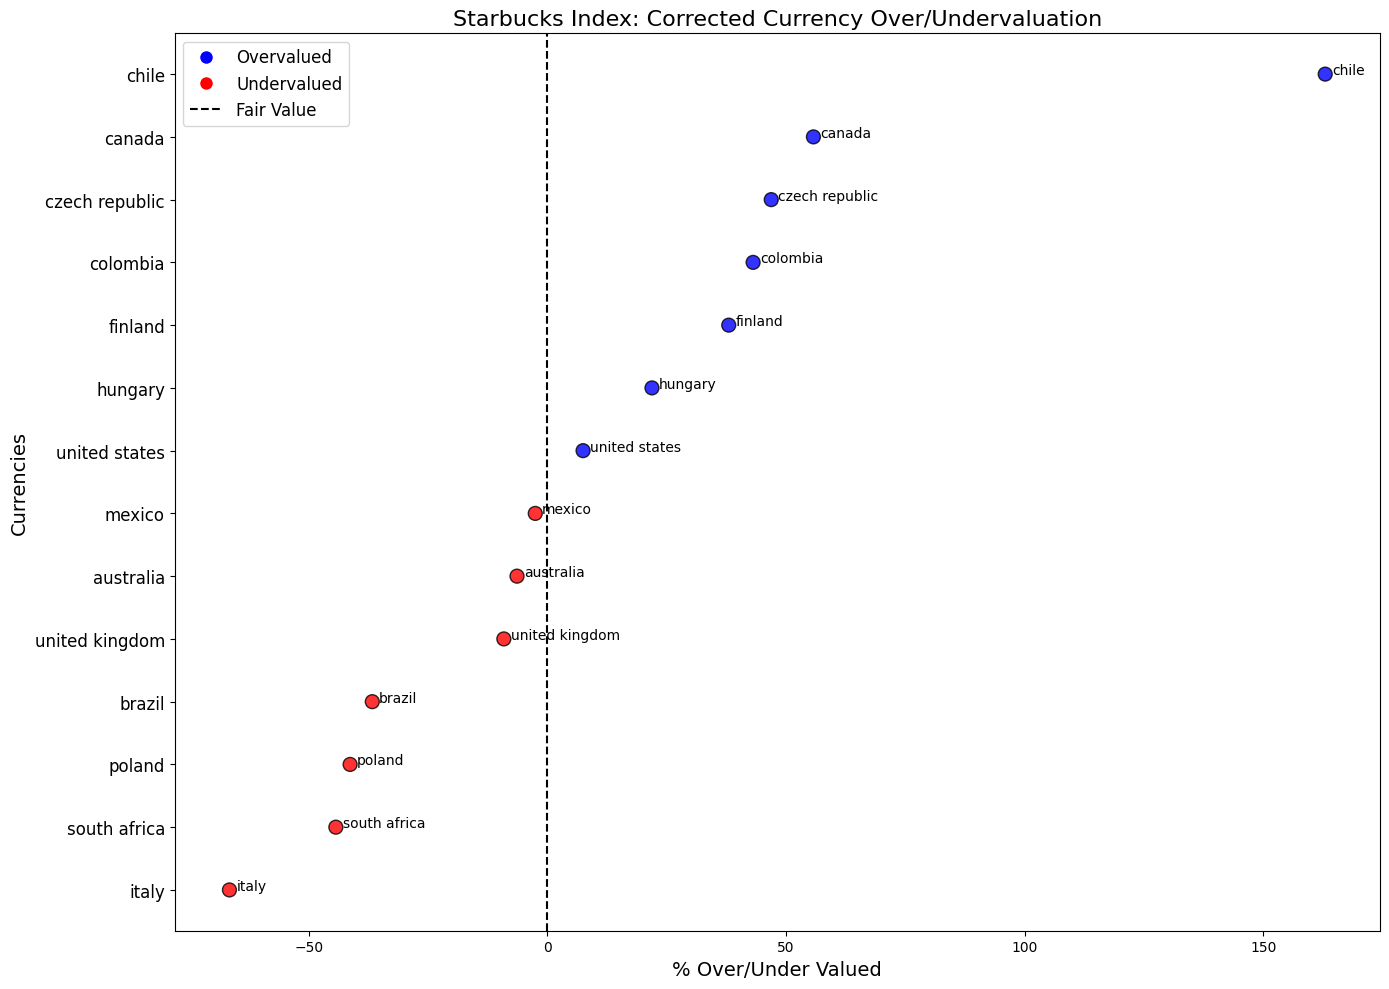

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Starbucks Index Data
file_path = "starbucks_index.csv"
df = pd.read_csv(file_path)

# Step 2: Convert columns to numeric (force errors to NaN)
df["PPP Exchange Rate (USD)"] = pd.to_numeric(df["PPP Exchange Rate (USD)"], errors="coerce")
df["Exchange Rate"] = pd.to_numeric(df["Exchange Rate"], errors="coerce")

# Step 3: Fix Currency Valuation Calculation (Corrected Logic)
df["Valuation %"] = ((df["PPP Exchange Rate (USD)"] - df["Exchange Rate"]) / df["Exchange Rate"]) * 100

# Step 4: **Fix Overvalued vs. Undervalued Logic**
def classify_currency(row):
    if row["PPP Exchange Rate (USD)"] < row["Exchange Rate"]:
        return "Undervalued"  # Currency is **cheaper** than expected
    elif row["PPP Exchange Rate (USD)"] > row["Exchange Rate"]:
        return "Overvalued"  # Currency is **more expensive** than expected
    else:
        return "Neutral"

df["Currency Valuation"] = df.apply(classify_currency, axis=1)

# Step 5: Sort for Better Visualization
df_sorted = df.sort_values(by="Valuation %", ascending=True)

# Step 6: Define Colors for Visualization
df_sorted["Color"] = df_sorted["Currency Valuation"].apply(lambda x: "red" if x == "Undervalued" else "blue")

# Step 7: Create Scatter Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(df_sorted["Valuation %"], range(len(df_sorted)), 
           c=df_sorted["Color"], alpha=0.8, edgecolors="black", linewidths=1, s=100, label="Currency Valuation")

# Step 8: Adjust Y-axis Labels to Display All Country Names
ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(df_sorted["Country"], fontsize=12, ha="right")

# Step 9: Add Country Annotations Next to Each Point
for i, txt in enumerate(df_sorted["Country"]):
    ax.annotate(txt, (df_sorted["Valuation %"].iloc[i], i), 
                textcoords="offset points", xytext=(5, 0), ha="left", fontsize=10)

# Step 10: Add Vertical Line for Neutral Valuation (0%)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Fair Value")

# Step 11: Add a Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Overvalued', markerfacecolor='blue', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='Undervalued', markerfacecolor='red', markersize=10),
           plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1.5, label="Fair Value")]

ax.legend(handles=handles, loc="upper left", fontsize=12)

# Step 12: Format Chart
ax.set_xlabel("% Over/Under Valued", fontsize=14)
ax.set_ylabel("Currencies", fontsize=14)
ax.set_title("Starbucks Index: Corrected Currency Over/Undervaluation", fontsize=16)

# Step 13: Show the Graph
plt.tight_layout()
plt.show()

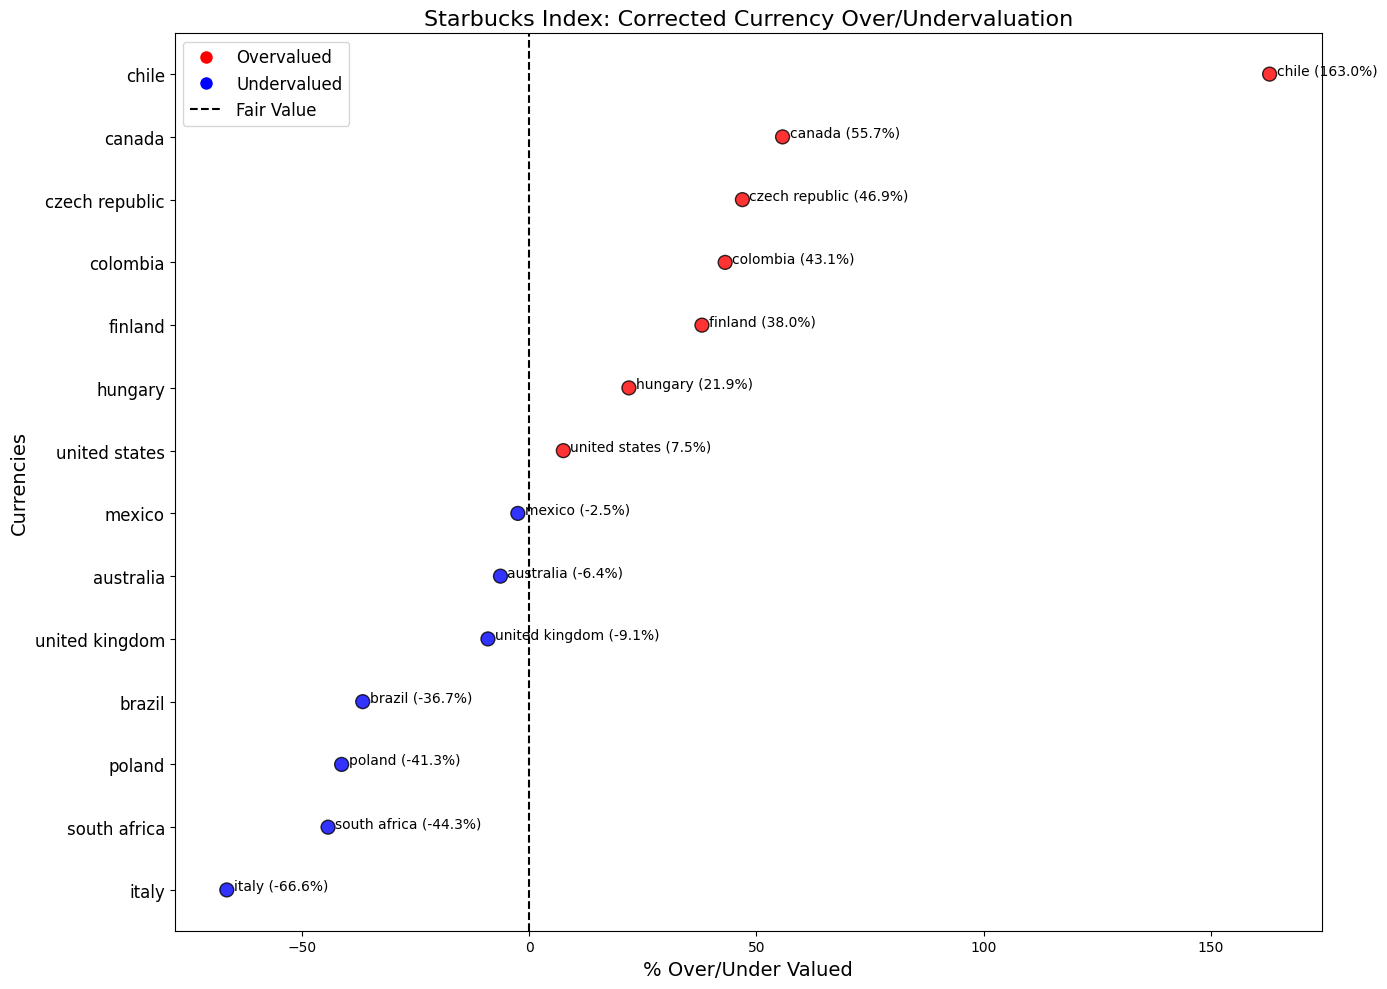

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Starbucks Index Data
file_path = "starbucks_index.csv"
df = pd.read_csv(file_path)

# Step 2: Convert columns to numeric (force errors to NaN)
df["PPP Exchange Rate (USD)"] = pd.to_numeric(df["PPP Exchange Rate (USD)"], errors="coerce")
df["Exchange Rate"] = pd.to_numeric(df["Exchange Rate"], errors="coerce")

# Step 3: Fix Currency Valuation Calculation (Corrected Logic)
df["Valuation %"] = ((df["PPP Exchange Rate (USD)"] - df["Exchange Rate"]) / df["Exchange Rate"]) * 100

# Step 4: **Fix Overvalued vs. Undervalued Logic**
def classify_currency(row):
    if row["PPP Exchange Rate (USD)"] < row["Exchange Rate"]:
        return "Undervalued"  # Currency is **cheaper** than expected
    elif row["PPP Exchange Rate (USD)"] > row["Exchange Rate"]:
        return "Overvalued"  # Currency is **more expensive** than expected
    else:
        return "Neutral"

df["Currency Valuation"] = df.apply(classify_currency, axis=1)

# Step 5: Sort for Better Visualization
df_sorted = df.sort_values(by="Valuation %", ascending=True)

# Step 6: Define Colors for Visualization
df_sorted["Color"] = df_sorted["Currency Valuation"].apply(lambda x: "blue" if x == "Undervalued" else "red")

# Step 7: Create Scatter Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(df_sorted["Valuation %"], range(len(df_sorted)), 
           c=df_sorted["Color"], alpha=0.8, edgecolors="black", linewidths=1, s=100, label="Currency Valuation")

# Step 8: Adjust Y-axis Labels to Display All Country Names
ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(df_sorted["Country"], fontsize=12, ha="right")

# Step 9: Add Country Annotations with **Percentage Values**
for i, txt in enumerate(df_sorted["Country"]):
    percentage = round(df_sorted["Valuation %"].iloc[i], 1)  # Round percentage to 1 decimal place
    ax.annotate(f"{txt} ({percentage}%)", 
                (df_sorted["Valuation %"].iloc[i], i), 
                textcoords="offset points", xytext=(5, 0), ha="left", fontsize=10)

# Step 10: Add Vertical Line for Neutral Valuation (0%)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Fair Value")

# Step 11: Add a Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Overvalued', markerfacecolor='red', markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='Undervalued', markerfacecolor='blue', markersize=10),
           plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1.5, label="Fair Value")]

ax.legend(handles=handles, loc="upper left", fontsize=12)

# Step 12: Format Chart
ax.set_xlabel("% Over/Under Valued", fontsize=14)
ax.set_ylabel("Currencies", fontsize=14)
ax.set_title("Starbucks Index: Corrected Currency Over/Undervaluation", fontsize=16)

# Step 13: Show the Graph
plt.tight_layout()
plt.show()

We can see that countries that are overvalued tend ot be significantly more overvalued than countries that are undervalued. This is especially true for the outlier that is Chile. If more analysis was to be done going in and making sure that the data was accurate for Chile would be important ot verify results. 